## Table of Contents
- [Overview](#overview)
- [Dataset Description](#describe)
- [Data Gathering](#gather)
- [Exploratory Data Analysis](#EDA)
- [Data Preprocessing](#process)
- [Modeling](#model)
- [Conclusion](#conclude)

<a id='overview'></a>
## Overview
Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!


To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!

<a id='describe'></a>
## Dataset Description
In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

### File and Data Field Descriptions

1. `train.csv` - Personal records for about two-thirds (~8700) of the passengers, to be used as training data. It contains the following columns:
- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination - The planet the passenger will be debarking to.
- Age - The age of the passenger.
- VIP - Whether the passenger has paid for special VIP service during the voyage.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name - The first and last names of the passenger.
- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.<br>

2. `test.csv` - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.<br>

3. `sample_submission.csv` - A submission file in the correct format.
- PassengerId - Id for each passenger in the test set.
- Transported - The target. For each passenger, predict either True or False.


In [1]:
# Load the necessary libraries
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import pickle
import os

%matplotlib inline

<a id='gather'></a>
## Data Gathering

In [2]:
# Unzip files
with zipfile.ZipFile('spaceship-titanic.zip', 'r') as f:
    f.extractall()

In [3]:
# Check available files in current directory
os.listdir()

['.ipynb_checkpoints',
 'corr_test.png',
 'corr_train.png',
 'hist_test.png',
 'hist_train.png',
 'homeplanet.png',
 'result.csv',
 'sample_submission.csv',
 'spaceship-titanic.zip',
 'test.csv',
 'train.csv',
 'Untitled.ipynb']

In [4]:
# Read files into dataframe
sample_df = pd.read_csv('sample_submission.csv')
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

<a id='EDA'></a>
## Exploratory Data Analysis

In [5]:
# Print first 5 rows
sample_df.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [6]:
# Print first 5 rows
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [7]:
# Print first 5 rows
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [8]:
# Check test df information
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [9]:
# Check NaNs in each column
test_df.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [10]:
# Check the number of unique values in each column
test_df.nunique()

PassengerId     4277
HomePlanet         3
CryoSleep          2
Cabin           3265
Destination        3
Age               79
VIP                2
RoomService      842
FoodCourt        902
ShoppingMall     715
Spa              833
VRDeck           796
Name            4176
dtype: int64

In [11]:
# Check number of unique values in each column
train_df.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

In [12]:
# Check NaNs across columns
train_df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [13]:
# Basic descriptive stat
test_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


In [14]:
# Descriptive stat
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [15]:
# Check train df information
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [16]:
# Descriptive stat
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


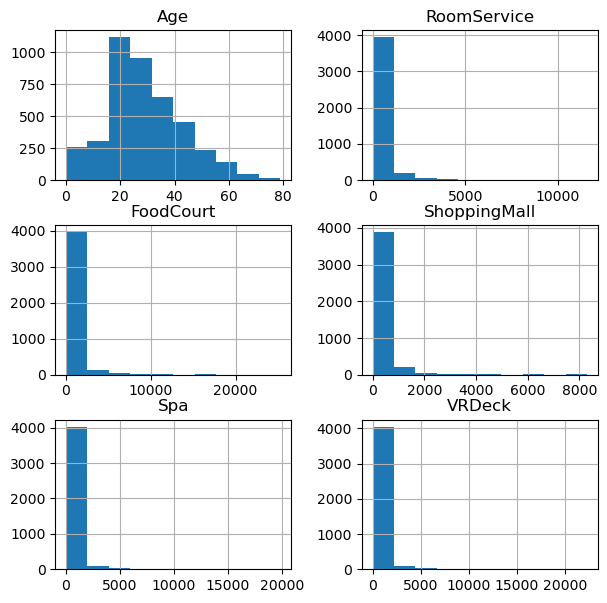

In [17]:
# EDA on test df
test_df.hist(figsize=[7,7]);
plt.savefig('hist_test.png');

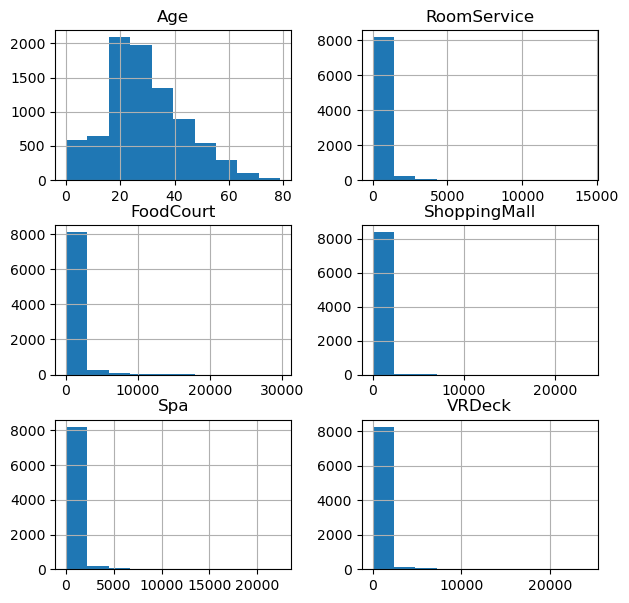

In [18]:
# EDA on train df
train_df.hist(figsize=[7,7]);
plt.savefig('hist_train.png');

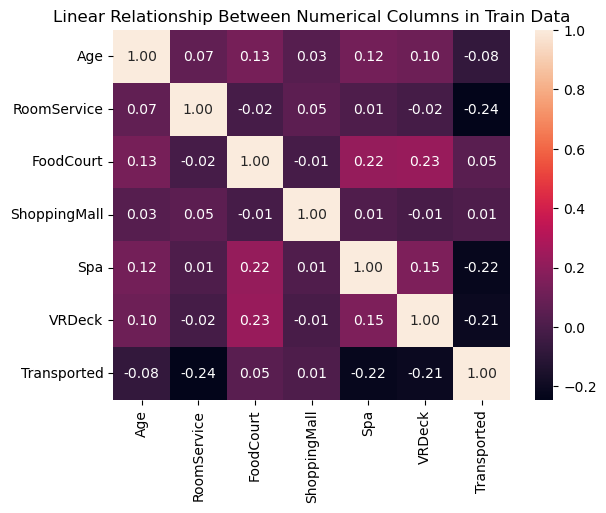

In [19]:
# Heatmap to check correlation of numeric columns in train df
sns.heatmap(train_df.corr(), annot=True, fmt='.2f');
plt.title('Linear Relationship Between Numerical Columns in Train Data');
plt.savefig('corr_train.png');

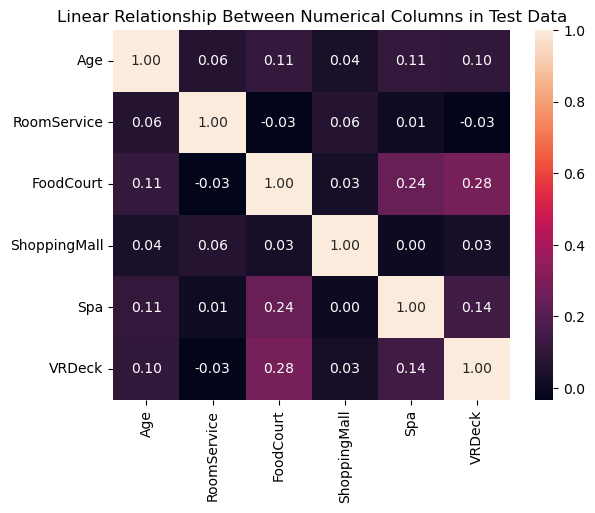

In [20]:
# Heatmap to check correlation of numeric columns in test df
sns.heatmap(test_df.corr(), annot=True, fmt='.2f');
plt.title('Linear Relationship Between Numerical Columns in Test Data');
plt.savefig('corr_test.png');

Above are heatmaps that display the linear relationships between the numerical columns in the train and test dataframes. The results from each cell show that there is no significant linear relationship between numerical columns. 

In [21]:
# Length of CabinNumber in train_df not in test_df
len(np.setdiff1d(train_df.Cabin.str.split('/', expand=True).get(1).astype(float)
             , test_df.Cabin.str.split('/', expand=True).get(1).astype(float)))

390

In [22]:
# Length of CabinNumber in test_df not in train_df
len(np.setdiff1d(test_df.Cabin.str.split('/', expand=True).get(1).astype(float)
             , train_df.Cabin.str.split('/', expand=True).get(1).astype(float)))

78

We have 390 Cabin Numbers in train_df that are not in test_df. Also 78 Cabin Numbers in test_df that are not in train_df. This indicates that the two dataframes need to be concatenated first before dummy operation to ensure that we have equal number of columns for the train and test dfs. 

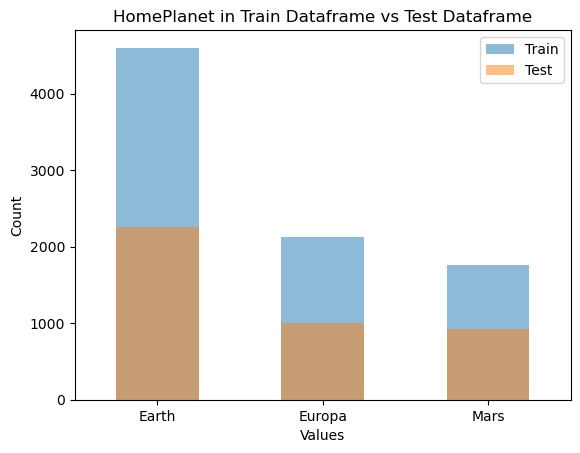

In [23]:
color = sns.color_palette()


def home_planet_plot():
    """
    Plot a bar graph of aggregated values in homeplanet
    column of train and test dataframes and compare their destribution.
    
    Parameters: 
           None
    Returns: 
         None
    """
        
    # Aggregate the total count of values in homeplanet and plot
    train_df.HomePlanet.value_counts().plot(
        kind = 'bar', 
        color = color[0], 
        alpha = .5, 
        label = 'Train'
    );
    
    test_df.HomePlanet.value_counts().plot(
        kind = 'bar', 
        color = color[1], 
        alpha = .5, 
        label = 'Test'
    );

    plt.xlabel('Values');
    plt.xticks(rotation = 0)
    plt.ylabel('Count');
    plt.title('HomePlanet in Train Dataframe vs Test Dataframe');
    plt.legend();
    plt.savefig('homeplanet.png');
home_planet_plot()

This bar graph shows the distribution of different home planets in both train and test dataframes. It shows that both columns from the different dataframes have the same trend.

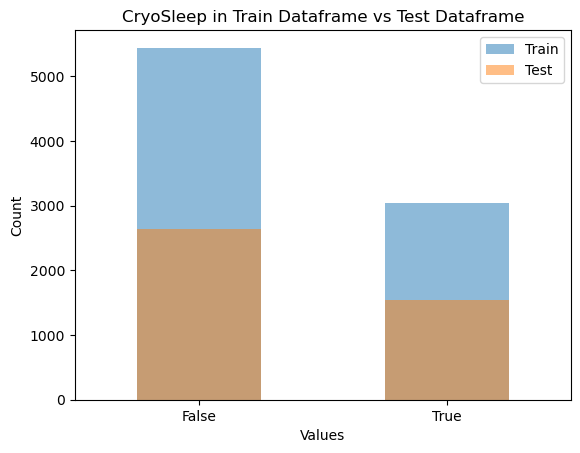

In [24]:
def cryosleep_plot():
    
    """
    Plot a bar graph of aggregated values of cryosleep in cabin
    column of train and test dataframes and compare their destribution.
    
    Parameters: 
           None
    Returns: 
         None
    """
    
    # Aggregate the total count of values in cryosleep column and plot
    train_df.CryoSleep.value_counts().plot(
        kind = 'bar', 
        color = color[0], 
        alpha = .5, 
        label = 'Train'
    );

    test_df.CryoSleep.value_counts().plot(
        kind = 'bar', 
        color = color[1], 
        alpha = .5, 
        label = 'Test'
    );

    plt.xlabel('Values');
    plt.xticks(rotation = 0);
    plt.ylabel('Count');
    plt.title('CryoSleep in Train Dataframe vs Test Dataframe');
    plt.legend();
    plt.savefig('cryosleep.png');
cryosleep_plot()

This bar graph also shows that CryoSleep column from different dataframes have the same trend.

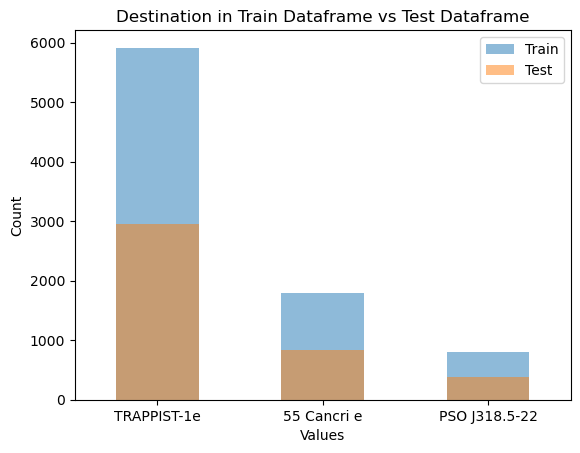

In [25]:
def destination_plot():

    """
    Plot a bar graph of aggregated values of destination column of train and test dataframes.
    
    Parameters: 
           None
    Returns: 
         None
    """
    
    train_df.Destination.value_counts().plot(
        kind = 'bar', 
        color = color[0], 
        alpha = .5, 
        label = 'Train'
    );
    
    test_df.Destination.value_counts().plot(
        kind = 'bar', 
        color = color[1], 
        alpha = .5, 
        label = 'Test'
    );


    plt.xlabel('Values');
    plt.xticks(rotation = 0)
    plt.ylabel('Count');
    plt.title('Destination in Train Dataframe vs Test Dataframe');
    plt.legend();
    plt.savefig('destination.png');
destination_plot()

This bar graph also shows that both columns from different dataframes have the same trend in destination column.

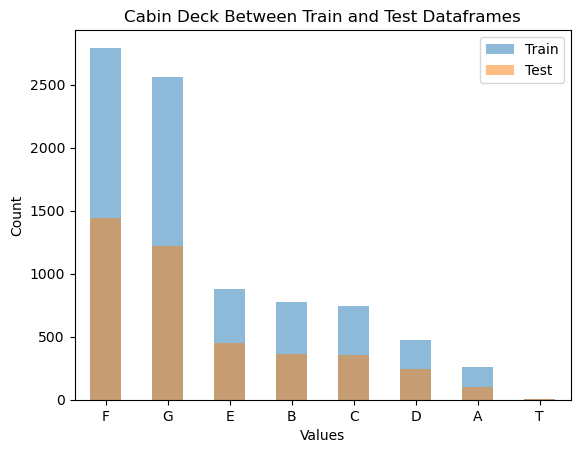

In [26]:
def cabin_deck_plot():
    
    """
    Plot a bar graph of aggregated values of cabin deck 
    in cabin column of train and test dataframes.
    
    Parameters: 
           None
    Returns: 
         None
    """
    
    # Extract cabin side values, aggregate them, and produce a bar plot
    train_df.Cabin.str.split('/', expand=True).get(0).value_counts().plot(
        kind = 'bar', 
        alpha = .5, 
        label = 'Train', 
        color = color[0]
    );
    test_df.Cabin.str.split('/', expand=True).get(0).value_counts().plot(
        kind = 'bar', 
        alpha = .5, 
        label = 'Test', 
        color = color[1]
    );

    plt.xlabel('Values');
    plt.xticks(rotation = 0)
    plt.ylabel('Count');
    plt.title('Cabin Deck Between Train and Test Dataframes');
    plt.legend();
    plt.savefig('cabin_deck.png');
cabin_deck_plot()

Both columns from different dataframes have the same trend of Cabin Deck.

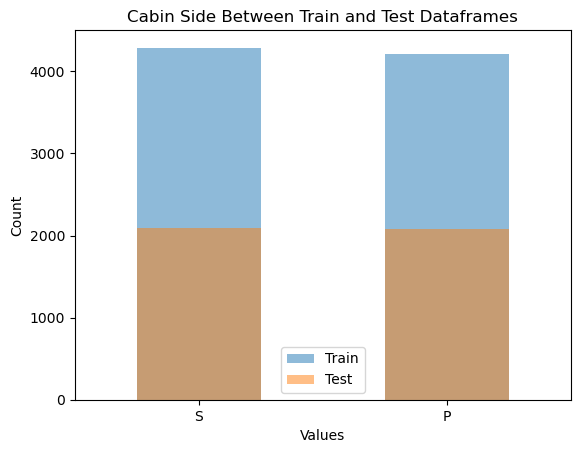

In [27]:
def cabin_side_plot():
    """
    Plot a bar graph of aggregated values of cabin side in cabin column of train and test dataframes.
    
    Parameters: 
           None
    Returns: 
         None
    """
    
    # Extract cabin side values, aggregate them, and produce a bar plot
    train_df.Cabin.str.split('/', expand=True).get(2).value_counts().plot(
        kind = 'bar', 
        color = color[0], 
        alpha = .5, 
        label = 'Train'
    );

    test_df.Cabin.str.split('/', expand=True).get(2).value_counts().plot(
        kind = 'bar', 
        color = color[1], 
        alpha = .5, 
        label = 'Test'
    );

    plt.xlabel('Values');
    plt.xticks(rotation = 0)
    plt.ylabel('Count');
    plt.title('Cabin Side Between Train and Test Dataframes');
    plt.legend();
    plt.savefig('cabin_side.png');
cabin_side_plot()

This bar graph shows the distribution of cabin sides. There is a similar trend between train dataframe and test dataframe in this column 

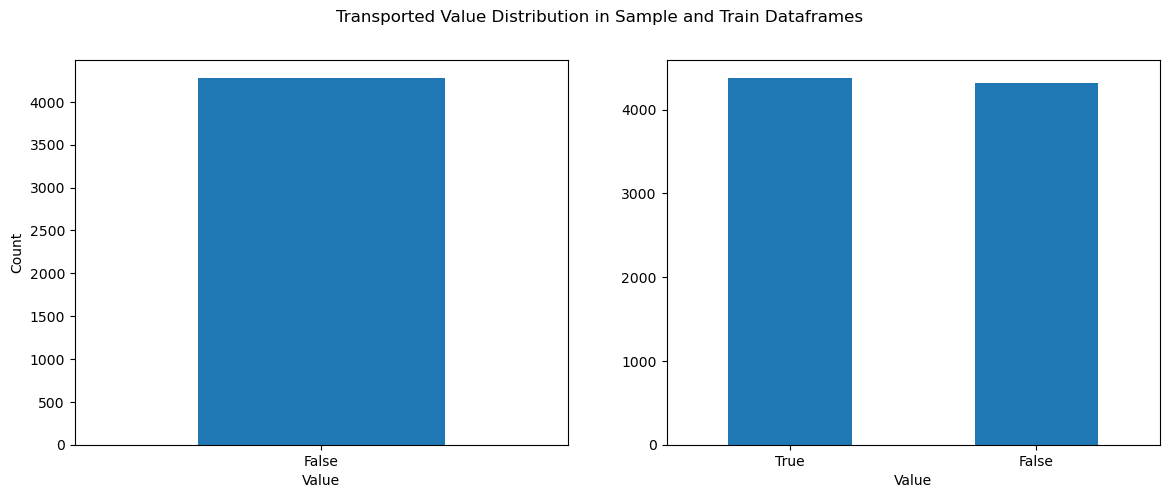

In [28]:
def transported_plot():
    
    """
    Plot a bar graph of aggregated values in Transported column in train and sample dataframes.
    
    Parameters: 
           None
    Returns: 
         None
    """
    
    plt.figure(figsize=[14,5])
    plt.subplot(121);

    sample_df.Transported.value_counts().plot(kind = 'bar');

    plt.xlabel('Value');
    plt.xticks(rotation = 0)
    plt.ylabel('Count');

    plt.subplot(122);

    train_df.Transported.value_counts().plot(kind = 'bar');


    plt.xlabel('Value');
    plt.xticks(rotation = 0)
    plt.suptitle('Transported Value Distribution in Sample and Train Dataframes');plt.savefig('reduce_dinension.png');
    plt.savefig('transported.png');
transported_plot()

The bar graph above shows the distribution of target variables (Transported) from train and sample dataframes. These columns will be used to test how well my model can predict. In train dataframe, this column consists of two values (True and False), but one value (False) in the sample dataframe. If you look closely, you'd observe that the frequency of False is approximately the same (over 4000). Why is this so? The `sample_df` has the exact same number of observations as `test_df`. This indicates a possible anomaly. While other columns in `test_df` have lower value counts than `train_df`, this one is different. This is the only column that does not have a similar trend with that of train dataframe. This indicates that my model may not predict well on the test data.

<a id='process'></a>
## Data Preprocessing

In [29]:
def clean_dummy(df1, df2):
    
    """
    Concatenate, wrangle and dummy dataframe .
    
    Parameters: 
           df1: X train dataframe
           df2: X test dataframe
    Returns: 
         X_train: cleaned and dummied X train matrix
         X_test: cleaned and dummied X test matrix
    """
    
    # Get a copy of the original data
    df1 = df1.copy()
    df2 = df2.copy()
    
    # Drop target column
    df1.drop('Transported', axis = 1, inplace = True)
    
    # Concatenate the two dfs together row-wise
    df = pd.concat([df1, df2], axis=0, ignore_index=True)
    
    # Get every numerical columns
    for col in df.select_dtypes(
        include=[
            'float', 
            'int'
        ]
    ).columns:
            
        # Replace NaNs with mean
        df[col].fillna(df[col].mean(), inplace=True)
    
    # Split cabin column and form new columns from it
    split_cabin = df.Cabin.str.split('/', expand=True)
    df['Cabin_Deck'] =split_cabin.get(0)
    df['Cabin_Number'] =split_cabin.get(1)
    df['Cabin_Side'] =split_cabin.get(2)
    
    # Drop Unwanted columns
    df.drop(
        [
            'PassengerId', 
            'Cabin', 
            'Name'
        ], 
        axis = 1, 
        inplace = True
    )
        
    #dummy all the categorical columns
    for col in df.select_dtypes(
        include=[
            'object', 
            'bool'
        ]
    ).columns:
        df = pd.concat(
            [
                df.drop(col, axis=1), 
                pd.get_dummies(
                    df[col], 
                    prefix=col,
                    prefix_sep='_', 
                    drop_first=True, 
                    dummy_na=True)
            ], axis=1
        )
        
    # Split the data back after dummy
    X_train = df[:df1.shape[0]]
    X_test = df[df1.shape[0]:].reset_index(drop = True)
    return X_train, X_test

In [30]:
X_train, X_test= clean_dummy(train_df, test_df)

In [31]:
# Check X_train
X_train.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_nan,CryoSleep_True,...,Cabin_Number_993,Cabin_Number_994,Cabin_Number_995,Cabin_Number_996,Cabin_Number_997,Cabin_Number_998,Cabin_Number_999,Cabin_Number_nan,Cabin_Side_S,Cabin_Side_nan
0,39.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,24.0,109.0,9.0,25.0,549.0,44.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,16.0,303.0,70.0,151.0,565.0,2.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [32]:
# Check X_train shape
X_train.shape

(8693, 1920)

In [33]:
# Check X_test
X_test.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_nan,CryoSleep_True,...,Cabin_Number_993,Cabin_Number_994,Cabin_Number_995,Cabin_Number_996,Cabin_Number_997,Cabin_Number_998,Cabin_Number_999,Cabin_Number_nan,Cabin_Side_S,Cabin_Side_nan
0,27.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,19.0,0.0,9.0,0.0,2823.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,31.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,38.0,0.0,6652.0,0.0,181.0,585.0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,20.0,10.0,0.0,635.0,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [34]:
# Check X_test shape
X_test.shape

(4277, 1920)

In [35]:
# Dummy target column
y_test = sample_df.Transported.map(
    {
        False: 0, 
        True: 1
    }
)
y_train = train_df.Transported.map(
    {
        False: 0, 
        True: 1
    }
)

<a id='model'></a>
## Modeling

In [36]:
def create_rf_model(X_train, X_test, y_train, y_test):
    
    """
    Create a random forest classifier and predict.
    
    Parameters: 
        X_ train, X_test - pandas dataframe, X matrix
        y_train, y_test - pandas dataframe, response variable
    Returns: 
        None
    """
    
    # Instantiate Sclassifier
    rf_model = RandomForestClassifier() 
    rf_model.fit(X_train, y_train) #Fit

    #Predict test data
    y_test_preds = rf_model.predict(X_test)
    
    # Predict train data
    y_train_preds = rf_model.predict(X_train)

    #Score the model
    
    print('Test Score ...')
    print('f1 score:', f1_score(y_test, y_test_preds, average= 'micro'))
    
    print('Train Score ...')
    print('f1 score:', f1_score(y_train, y_train_preds, average= 'micro'))
    
create_rf_model(X_train, X_test, y_train, y_test)

Test Score ...
f1 score: 0.5040916530278232
Train Score ...
f1 score: 0.9995398596571955


In [37]:
def find_optimal_rf_mod(cutoffs, X_train, X_test, y_train, y_test, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r1_scores_test - list of floats of r1 scores on the test data
    r1_scores_train - list of floats of r1 scores on the train data
    rf_model - model object from sklearn
    X_train, X_test, best_cutoff - X matrices and the best cutoff for optimal model
    '''
    f1_scores_test, f1_scores_train, num_feats = [], [], []
    
    # Concatenate dataframes row-wise
    X_concat = pd.concat([X_train, X_test], ignore_index=True)
    for cutoff in cutoffs:

        # Reduce X matrix
        
        reduce_X = X_concat.iloc[:, np.where((X_concat.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        # Split the data back into train and test
        X_train = reduce_X[0: 8693]
        X_test = reduce_X[8693:]

        # Fit the model and obtain pred response
        rf_model = RandomForestClassifier()
        rf_model.fit(X_train, y_train)
        y_test_preds = rf_model.predict(X_test)
        y_train_preds = rf_model.predict(X_train)

        # Append the f1 value from the test set
        f1_scores_test.append(f1_score(y_test, y_test_preds, average= 'micro'))
        f1_scores_train.append(f1_score(y_train, y_train_preds, average= 'micro'))
    
    # Get the best cutoff value
    best_cutoff = cutoffs[np.where(np.array(f1_scores_test) == np.array(f1_scores_test).max())[0][0]]
        
    if plot:
        plt.plot(num_feats, f1_scores_test, label="Test")
        plt.plot(num_feats, f1_scores_train, label="Train")
        plt.xlabel('Number of Features')
        plt.ylabel('F1 score')
        plt.title('F1 score by Number of Features')
        plt.legend(loc=4)
        plt.grid()
        plt.show()
        plt.savefig('reduce_dinension.png');

    return X_train, X_test, best_cutoff

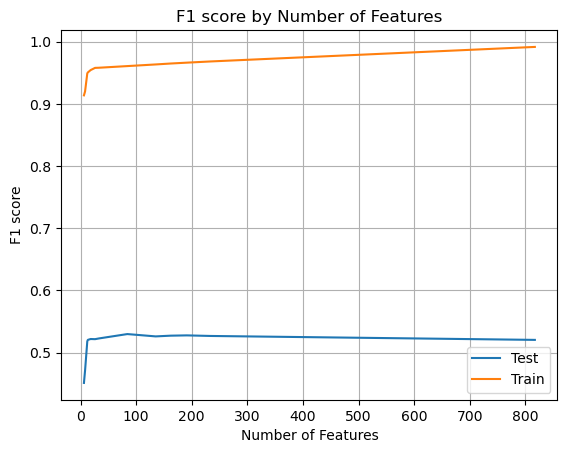

<Figure size 640x480 with 0 Axes>

In [38]:
#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model.

cutoffs = [70000, 5000, 3000, 1500, 500, 50, 25, 20, 18, 17, 16, 15, 5]

X_train_opt, X_test_opt, best_cutoff= find_optimal_rf_mod(cutoffs, X_train, X_test, y_train, y_test)

In [39]:
# Print best cutoff value
best_cutoff

20

The plot above shows different f1 scores based on the number of features. As the number of features increases, the score improves. Test score peaks at about 0.53 with 100 features. Beyond this, the plot flattens and tends to slope a little downwards as features increase. Train score increases progressively as features increase.

In [40]:
def improve_rf_model_1(X_train, X_test ,y_train,y_test):
    
    """
    Improve model with hyperparameters.
    
    Parameters: 
           X_train: X metrix for training the model
           X_test: X matrix for prediction
           y_train: y matrix for training the model
           y_test: y matrix for testing the model's performance
    Returns: 
         df
    """
    
    parameters = {
        
        'n_estimators':[100, 300],
        'min_samples_split' : [5,10,15],
        'min_samples_leaf' : [4,6,8],
        'max_depth': [30, 40]
    }
    
    # Instatiate gridsearch
    cv = GridSearchCV(
        RandomForestClassifier(), 
        param_grid=parameters
    ) 
    
    #Fit gridsearch
    cv.fit(X_train, y_train)
    
    # Predict X_test
    y_test_preds_cv = cv.predict(X_test)
    
    # Predict X_train
    y_train_preds_cv = cv.predict(X_train)
    
    print('Improved Test Score ...')
    print('f1 score test...:', f1_score(y_test, y_test_preds_cv, average= 'micro'))
    
    print("Best Parameters:", cv.best_params_)
    
    print('Improved Train Score ...')
    print('f1 score train...:', f1_score(y_train, y_train_preds_cv, average= 'micro'))
    
improve_rf_model_1(X_train, X_test, y_train, y_test)

Improved Test Score ...
f1 score test...: 0.5707271451952303
Best Parameters: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 3}
Improved Train Score ...
f1 score train...: 0.7733808811687565


In [41]:
def improve_rf_model_2(X_train, X_test ,y_train,y_test):
    
    """
    Improve model using with reduced features.
    
    Parameters: 
           optimum train and test data
    Returns: 
         df
    """
    
    parameters = {
        
        'n_estimators':[100, 300],
        'min_samples_split' : [5,10,15],
        'min_samples_leaf' : [4,6,8],
        'max_depth': [30, 40]
    }
    
    # Instatiate gridsearch
    cv = GridSearchCV(
        RandomForestClassifier(), 
        param_grid=parameters
    ) 
    
    #Fit gridsearch
    cv.fit(X_train, y_train)
    
    # Predict X_test
    y_test_preds_cv = cv.predict(X_test)
    
    # Predict X_train
    y_train_preds_cv = cv.predict(X_train)
    
    print('Improved Test Score ...')
    print('f1 score test...:', f1_score(y_test, y_test_preds_cv, average= 'micro'))
    
    print("Best Parameters:", cv.best_params_)
    
    print('Improved Train Score ...')
    print('f1 score train...:', f1_score(y_train, y_train_preds_cv, average= 'micro'))
    
    return y_test_preds_cv
y_test_preds_cv = improve_rf_model_2(X_train_opt, X_test_opt, y_train, y_test)

Improved Test Score ...
f1 score test...: 0.5711947626841244
Best Parameters: {'max_depth': 40, 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 100}
Improved Train Score ...
f1 score train...: 0.7562406533992868


In [42]:
def create_dataframe(y_pred,  df):
    
    """
    Form a dataframe and append result and save it.
    
    Parameters: 
           y_pred: predicted result
           df: sample_df
    Returns: 
         df
    """
    
    result_df = pd.DataFrame(
        columns=[
            'PassengerId', 
            'Transported'
        ]
    )
    result_df.loc[:, 'PassengerId'] = df.PassengerId
    result_df.loc[:, 'Transported'] = y_pred
    result_df.to_csv('result.csv', index = False)
    return result_df
    
result_df = create_dataframe(y_test_preds_cv, sample_df)

In [43]:
# Check result_df
result_df.head()

,PassengerId,Transported
0,0013_01,1
1,0018_01,0
2,0019_01,1
3,0021_01,1
4,0023_01,0


In [44]:
# Check how much data is explained by the model
result_df.mean()

PassengerId         inf
Transported    0.428805
dtype: float64

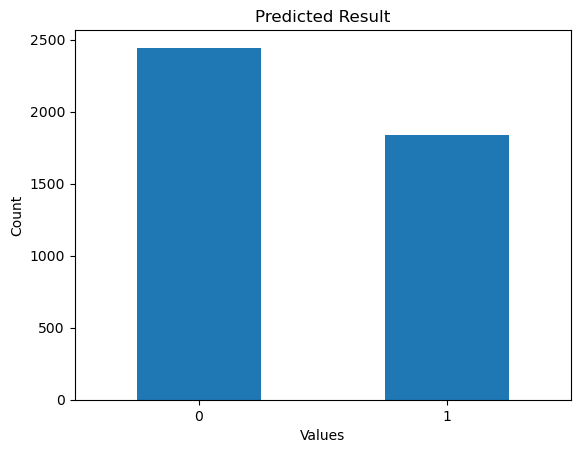

In [45]:
def result_plot():
    
    """
    Plot a bar graph of predicted values in the result_df.
    
    Parameters: 
           None
    Returns: 
         None
    """
    result_df.Transported.value_counts().plot(kind = 'bar');
    plt.xlabel('Values');
    plt.xticks(rotation = 0)
    plt.ylabel('Count');

    plt.title('Predicted Result');
    plt.savefig('result_plot.png');
result_plot()

The bar graph above shows the amount of data explained by my model. 0 represents False, 1 represents True.  About 2500 values are predicted correctly as False and about 1800 values are predicted wrongly as True. This is as expected due to the discrepancy in the trends noted earlier.

<a id='conclude'></a>
## Conclusion

The main task of this project was to predict the value of Transported for the passengers in the test data set. During the process, the following points were observed:
1. While EDA was conducted, it was observed that all other features maintained similar trends except Transported columns. This is a possible reason my model performed poorly on the test data
2. My initial f1 score was 0.5040. It became better after feature reduction with a score of 0.5711 